<div style=" background-color: RGB(0,114,200);" >
<h1 style="margin: auto; padding: 7px 0; color:#fff; text-align: center">PROJET 5</h1>
<h2 style="margin: auto; padding: 15px 0; color:#fff; text-align: center">BottleNeck - Optimiser la gestion des données d'une boutique
</h2>
</div>

In [164]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
import xlrd
from wordcloud import WordCloud
from PIL import Image

In [165]:
erp = pd.read_excel("../Source/Fichier_erp.xlsx")
liaison = pd.read_excel("../Source/fichier_liaison.xlsx")
web = pd.read_excel("../Source/Fichier_web.xlsx")

/Users/ishemzerzour/Desktop/My Program Files/Projet_5-BottleNeck/venv/lib/python3.11/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/Users/ishemzerzour/Desktop/My Program Files/Projet_5-BottleNeck/venv/lib/python3.11/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/Users/ishemzerzour/Desktop/My Program Files/Projet_5-BottleNeck/venv/lib/python3.11/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


<div style="background-color: RGB(0,150,250);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">Etape 1 - Exploration du fichier ERP (Référence produit)</h2>
</div>

In [166]:
erp

,product_id,onsale_web,price,stock_quantity,stock_status
0,3847,1,24.2,0,outofstock
1,3849,1,34.3,0,outofstock
2,3850,1,20.8,0,outofstock
3,4032,1,14.1,0,outofstock
4,4039,1,46.0,0,outofstock
...,...,...,...,...,...
820,7203,0,45.0,30,instock
821,7204,0,45.0,9,instock
822,7247,1,54.8,23,instock
823,7329,0,26.5,14,instock


In [167]:
erp = erp.drop_duplicates()

In [168]:
#changer le type de la colonne product_id
erp["product_id"] = erp["product_id"].astype(object)

In [169]:
erp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 825 entries, 0 to 824
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   product_id      825 non-null    object 
 1   onsale_web      825 non-null    int64  
 2   price           825 non-null    float64
 3   stock_quantity  825 non-null    int64  
 4   stock_status    825 non-null    object 
dtypes: float64(1), int64(2), object(2)
memory usage: 32.4+ KB


In [170]:
#product_id = Unique ? OUI 
print(erp['product_id'].nunique())
print('Les id produits sont uniques')
#stock_status = Quantité de stock / Boolean
print(erp['stock_status'].nunique())
print('Les stocks sont épuisés ou non')
#onsale_web = Produits mis en ligne ou non / Boolean
print(erp['onsale_web'].nunique())
print('Produit mis en ligne ou non')


825
Les id produits sont uniques
2
Les stocks sont épuisés ou non
2
Produit mis en ligne ou non


In [171]:
erp["price"] = erp["price"].abs()
erp["stock_quantity"] = erp["stock_quantity"].abs()
erp.describe()

,onsale_web,price,stock_quantity
count,825.000000,825.000000,825.000000
mean,0.869091,32.405818,26.587879
std,0.337506,26.805885,45.873135
min,0.000000,1.000000,0.000000
25%,1.000000,14.600000,1.000000
50%,1.000000,24.400000,11.000000
75%,1.000000,42.000000,34.000000
max,1.000000,225.000000,578.000000


In [172]:
erp

,product_id,onsale_web,price,stock_quantity,stock_status
0,3847,1,24.2,0,outofstock
1,3849,1,34.3,0,outofstock
2,3850,1,20.8,0,outofstock
3,4032,1,14.1,0,outofstock
4,4039,1,46.0,0,outofstock
...,...,...,...,...,...
820,7203,0,45.0,30,instock
821,7204,0,45.0,9,instock
822,7247,1,54.8,23,instock
823,7329,0,26.5,14,instock


In [173]:
erp['stock_status_ok'] = 'instock'
erp.loc[erp['stock_quantity'] == 0, 'stock_status_ok'] = 'outofstock'
erp = erp.drop(columns="stock_status")
erp

,product_id,onsale_web,price,stock_quantity,stock_status_ok
0,3847,1,24.2,0,outofstock
1,3849,1,34.3,0,outofstock
2,3850,1,20.8,0,outofstock
3,4032,1,14.1,0,outofstock
4,4039,1,46.0,0,outofstock
...,...,...,...,...,...
820,7203,0,45.0,30,instock
821,7204,0,45.0,9,instock
822,7247,1,54.8,23,instock
823,7329,0,26.5,14,instock


<div style="background-color: RGB(0,150,250);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">Etape 2 - Exploration du fichier Liaison</h2>
</div>

In [174]:
liaison

,product_id,id_web
0,3847,15298
1,3849,15296
2,3850,15300
3,4032,19814
4,4039,19815
...,...,...
820,7203,NaN
821,7204,NaN
822,7247,13127-1
823,7329,14680-1


In [175]:
#Renommer la colonne id_web en sku
liaison = liaison.rename(columns={'id_web': 'sku'})
liaison.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 825 entries, 0 to 824
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   product_id  825 non-null    int64 
 1   sku         734 non-null    object
dtypes: int64(1), object(1)
memory usage: 13.0+ KB


In [176]:
liaison = liaison.drop_duplicates()

In [177]:
#changer le type integer de la colonne product_id en string
liaison["sku"] = liaison["sku"].astype(object)


In [178]:
#on va verifier si les product id sont unique
print(liaison['product_id'].nunique())
print("les product_id sont bien uniques")
#on va verifier si les sku sont unique
print(liaison['sku'].nunique())
print("les sku ne sont pas uniques")

825
les product_id sont bien uniques
734
les sku ne sont pas uniques


In [179]:
liaison.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 825 entries, 0 to 824
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   product_id  825 non-null    int64 
 1   sku         734 non-null    object
dtypes: int64(1), object(1)
memory usage: 13.0+ KB


In [180]:
liaison

,product_id,sku
0,3847,15298
1,3849,15296
2,3850,15300
3,4032,19814
4,4039,19815
...,...,...
820,7203,NaN
821,7204,NaN
822,7247,13127-1
823,7329,14680-1


<div style="background-color: RGB(0,150,250);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">Etape 3 - Analyse du fichier ERP avec Liaison</h2>
</div>

In [181]:
#1 : Je merge ERP et web_liaison
erp_liaison = pd.merge(erp, liaison, how="inner", on="product_id")
erp_liaison = erp_liaison.reset_index(drop=True)
erp_liaison

,product_id,onsale_web,price,stock_quantity,stock_status_ok,sku
0,3847,1,24.2,0,outofstock,15298
1,3849,1,34.3,0,outofstock,15296
2,3850,1,20.8,0,outofstock,15300
3,4032,1,14.1,0,outofstock,19814
4,4039,1,46.0,0,outofstock,19815
...,...,...,...,...,...,...
820,7203,0,45.0,30,instock,NaN
821,7204,0,45.0,9,instock,NaN
822,7247,1,54.8,23,instock,13127-1
823,7329,0,26.5,14,instock,14680-1


##### Un INNER JOIN garantira que seuls les produits présents dans les deux tables (avec des id_produits correspondants) seront inclus dans le résultat. On avait 825 product_id dans erp et 825 product_id dans liaison

##### La table jointe en a 825 également, ce qui indique que chaque ligne à sa correspondance unique

In [182]:
#On séléctionne les produits qui sont vendus en ligne
erp_liaison = erp_liaison.loc[erp_liaison['onsale_web'] == 1].reset_index(drop=True)
erp_liaison

,product_id,onsale_web,price,stock_quantity,stock_status_ok,sku
0,3847,1,24.2,0,outofstock,15298
1,3849,1,34.3,0,outofstock,15296
2,3850,1,20.8,0,outofstock,15300
3,4032,1,14.1,0,outofstock,19814
4,4039,1,46.0,0,outofstock,19815
...,...,...,...,...,...,...
712,6930,1,8.4,83,instock,16135
713,7023,1,27.5,15,instock,15891
714,7025,1,69.0,2,instock,15887
715,7247,1,54.8,23,instock,13127-1


In [183]:
erp_liaison.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 717 entries, 0 to 716
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   product_id       717 non-null    object 
 1   onsale_web       717 non-null    int64  
 2   price            717 non-null    float64
 3   stock_quantity   717 non-null    int64  
 4   stock_status_ok  717 non-null    object 
 5   sku              714 non-null    object 
dtypes: float64(1), int64(2), object(3)
memory usage: 33.7+ KB


In [184]:
#On affiche les 3 lignes ayant un sku null
df_sku_null = erp_liaison.loc[erp_liaison['sku'].isnull()]
df_sku_null

,product_id,onsale_web,price,stock_quantity,stock_status_ok,sku
228,4594,1,144.0,0,outofstock,NaN
449,5070,1,84.7,0,outofstock,NaN
450,5075,1,43.3,0,outofstock,NaN


In [185]:
# Il n'y a que 3 lignes avec un sku null pour les produits vendus en ligne = On supprime ces lignes 
erp_liaison = erp_liaison.dropna(subset=['sku']).reset_index(drop=True)
erp_liaison.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 714 entries, 0 to 713
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   product_id       714 non-null    object 
 1   onsale_web       714 non-null    int64  
 2   price            714 non-null    float64
 3   stock_quantity   714 non-null    int64  
 4   stock_status_ok  714 non-null    object 
 5   sku              714 non-null    object 
dtypes: float64(1), int64(2), object(3)
memory usage: 33.6+ KB


<div style="background-color: RGB(0,150,250);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">Etape 4 - Exploration du fichier Web (Produits commercialisés en ligne)</h2>
</div>

In [186]:
#Boucle afin de régler le problème d'encodage
def clean_html_tags(text):
    if pd.isna(text):
        return text
    else:
        soup = BeautifulSoup(text, "html.parser")
        return soup.get_text()
web["post_excerpt"] = web["post_excerpt"].apply(clean_html_tags)



/var/folders/rg/h0w5cjr90257kx52nm8zrv280000gn/T/ipykernel_43353/2550265802.py:6: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


In [187]:
#remplacer tout les 0 du df par NaN et supp ligne NaN
web.replace(0, np.nan, inplace=True)
web.dropna(axis=0,how='all', inplace=True)
web = web.reset_index(drop=True)
web

,sku,virtual,downloadable,rating_count,average_rating,total_sales,tax_status,tax_class,post_author,post_date,...,post_name,post_modified,post_modified_gmt,post_content_filtered,post_parent,guid,menu_order,post_type,post_mime_type,comment_count
0,16004,NaN,NaN,NaN,NaN,5.0,NaN,NaN,2.0,2018-06-07 16:27:25,...,chateau-du-couvent-pomerol-2017,2020-08-25 18:35:02,2020-08-25 16:35:02,NaN,NaN,https://www.bottle-neck.fr/wp-content/uploads/...,NaN,attachment,image/jpeg,NaN
1,15075,NaN,NaN,NaN,NaN,3.0,taxable,NaN,2.0,2018-02-14 15:39:43,...,pares-balta-penedes-indigena-2017,2020-08-20 15:35:02,2020-08-20 13:35:02,NaN,NaN,https://www.bottle-neck.fr/?post_type=product&...,NaN,product,NaN,NaN
2,16209,NaN,NaN,NaN,NaN,6.0,taxable,NaN,2.0,2018-02-14 17:15:31,...,maurel-cabardes-tradition-2017,2020-08-05 18:05:03,2020-08-05 16:05:03,NaN,NaN,https://www.bottle-neck.fr/?post_type=product&...,NaN,product,NaN,NaN
3,15763,NaN,NaN,NaN,NaN,1.0,NaN,NaN,2.0,2020-01-25 14:08:16,...,domaine-de-la-monardiere-vacqueyras-les-vieill...,2020-08-21 11:35:02,2020-08-21 09:35:02,NaN,NaN,https://www.bottle-neck.fr/wp-content/uploads/...,NaN,attachment,image/jpeg,NaN
4,13895,NaN,NaN,NaN,NaN,NaN,taxable,NaN,2.0,2019-03-19 10:41:50,...,chateau-saransot-dupre-bordeaux-blanc-2016,2020-04-25 21:11:40,2020-04-25 19:11:40,NaN,NaN,https://www.bottle-neck.fr/?post_type=product&...,NaN,product,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1425,12881,NaN,NaN,NaN,NaN,2.0,NaN,NaN,2.0,2019-03-28 15:25:14,...,montbourgeau-etoile-vin-jaune-2009,2019-12-30 10:30:01,2019-12-30 09:30:01,NaN,NaN,https://www.bottle-neck.fr/wp-content/uploads/...,NaN,attachment,image/jpeg,NaN
1426,15663,NaN,NaN,NaN,NaN,3.0,taxable,NaN,2.0,2018-02-27 10:27:01,...,chermette-domaine-du-vissoux-brouilly-pierreux...,2020-08-01 09:35:02,2020-08-01 07:35:02,NaN,NaN,https://www.bottle-neck.fr/?post_type=product&...,NaN,product,NaN,NaN
1427,15910,NaN,NaN,NaN,NaN,NaN,taxable,NaN,2.0,2019-03-28 10:59:43,...,thevenet-quintaine-vire-clesse-la-bongran-2015,2020-08-14 10:45:02,2020-08-14 08:45:02,NaN,NaN,https://www.bottle-neck.fr/?post_type=product&...,NaN,product,NaN,NaN
1428,38,NaN,NaN,NaN,NaN,38.0,NaN,NaN,2.0,2018-04-18 12:25:58,...,emile-boeckel-cremant-brut-blanc-de-blancs,2020-08-27 17:15:03,2020-08-27 15:15:03,NaN,NaN,https://www.bottle-neck.fr/wp-content/uploads/...,NaN,attachment,image/jpeg,NaN


In [188]:
#On vérifie s'il y a des duplicate : Pas de dublicate
web[web.duplicated()]

,sku,virtual,downloadable,rating_count,average_rating,total_sales,tax_status,tax_class,post_author,post_date,...,post_name,post_modified,post_modified_gmt,post_content_filtered,post_parent,guid,menu_order,post_type,post_mime_type,comment_count


comment_count            1.000000
post_password            1.000000
downloadable             1.000000
rating_count             1.000000
average_rating           1.000000
tax_class                1.000000
menu_order               1.000000
post_parent              1.000000
post_content             1.000000
post_content_filtered    1.000000
virtual                  1.000000
post_mime_type           0.500699
tax_status               0.499301
post_excerpt             0.499301
total_sales              0.460140
sku                      0.001399
ping_status              0.000000
comment_status           0.000000
post_name                0.000000
post_modified            0.000000
post_modified_gmt        0.000000
post_title               0.000000
post_date_gmt            0.000000
guid                     0.000000
post_date                0.000000
post_type                0.000000
post_author              0.000000
post_status              0.000000
dtype: float64


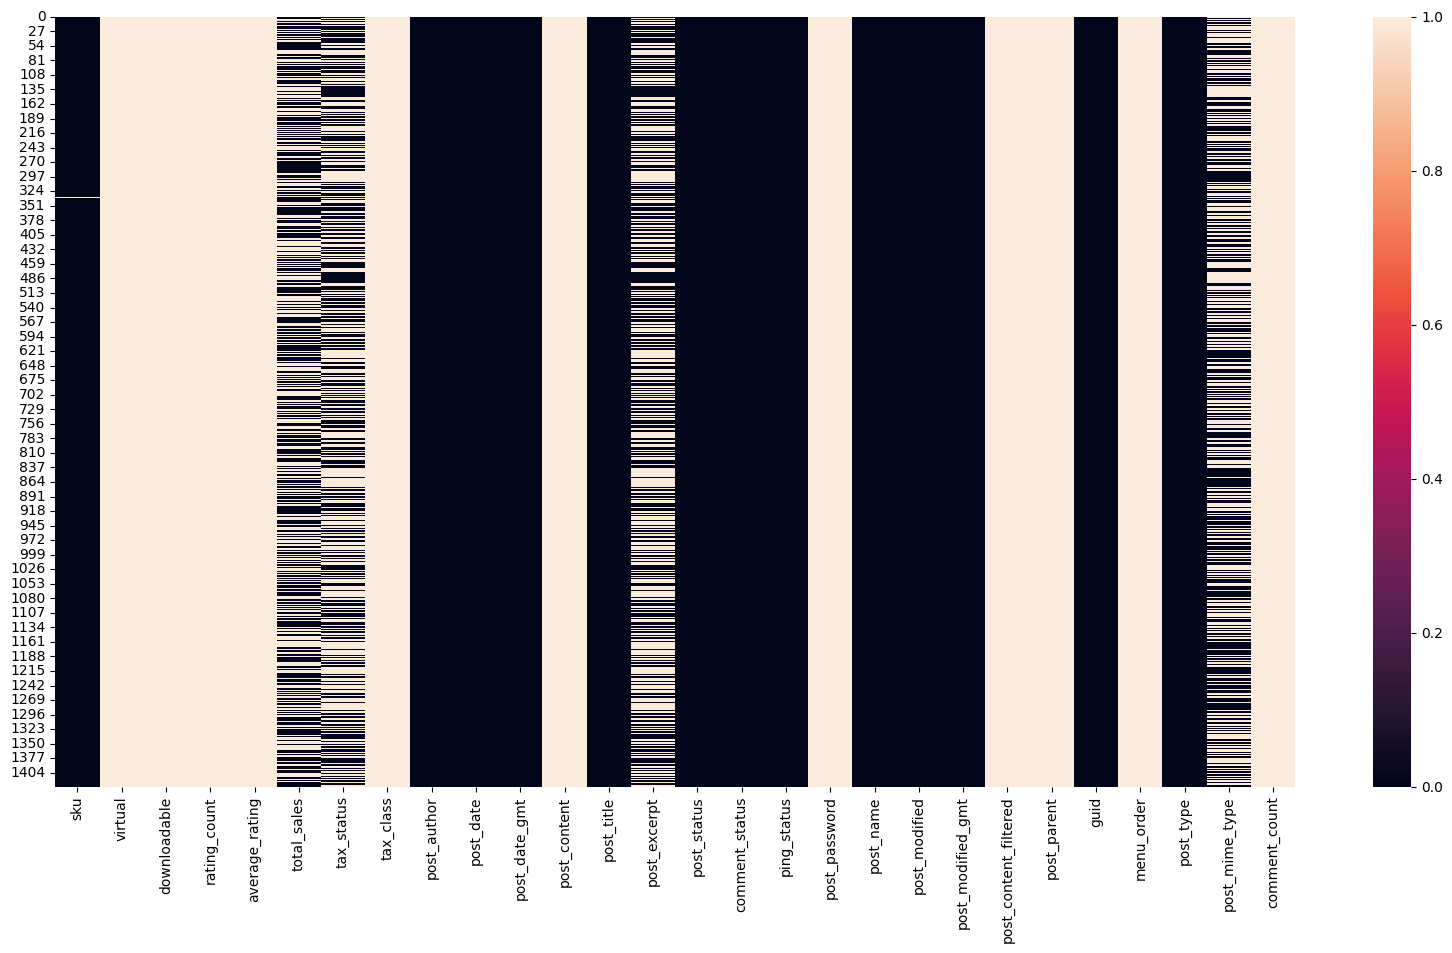

In [189]:
plt.figure(figsize=(20,10))
sns.heatmap(web.isna())
print((web.isna().sum()/web.shape[0]).sort_values(ascending=False))
web = web[web.columns[web.isna().sum()/web.shape[0] < 0.5]]

In [190]:
web = web.loc[web['post_type'] == 'product'].reset_index(drop=True)
web.head()

,sku,total_sales,tax_status,post_author,post_date,post_date_gmt,post_title,post_excerpt,post_status,comment_status,ping_status,post_name,post_modified,post_modified_gmt,guid,post_type
0,15075,3.0,taxable,2.0,2018-02-14 15:39:43,2018-02-14 14:39:43,Parés Baltà Penedès Indigena 2017,Des couleurs et aromes intenses où le fruit et...,publish,closed,closed,pares-balta-penedes-indigena-2017,2020-08-20 15:35:02,2020-08-20 13:35:02,https://www.bottle-neck.fr/?post_type=product&...,product
1,16209,6.0,taxable,2.0,2018-02-14 17:15:31,2018-02-14 16:15:31,Maurel Cabardès Tradition 2017,"Un joli nez aux arômes de fruits rouges, de ca...",publish,closed,closed,maurel-cabardes-tradition-2017,2020-08-05 18:05:03,2020-08-05 16:05:03,https://www.bottle-neck.fr/?post_type=product&...,product
2,13895,NaN,taxable,2.0,2019-03-19 10:41:50,2019-03-19 09:41:50,Château Saransot-Dupré Bordeaux Blanc 2016,Rareté en Médoc (mais d’A.O.C. Bordeaux) le do...,publish,closed,closed,chateau-saransot-dupre-bordeaux-blanc-2016,2020-04-25 21:11:40,2020-04-25 19:11:40,https://www.bottle-neck.fr/?post_type=product&...,product
3,12857,NaN,taxable,2.0,2018-04-12 17:56:13,2018-04-12 15:56:13,Château de Meursault Puligny-Montrachet 1er Cr...,Il présente une grande fraîcheur minérale au n...,publish,closed,closed,chateau-de-puligny-montrachet-1cru-champ-canet...,2020-02-06 16:35:02,2020-02-06 15:35:02,https://www.bottle-neck.fr/?post_type=product&...,product
4,14106,NaN,taxable,2.0,2019-06-08 09:54:21,2019-06-08 07:54:21,Stéphane Tissot Château-Chalon 2011,Ce vin peut-être dégusté sur sa jeunesse mais ...,publish,closed,closed,stephane-tissot-chateau-chalon-2011,2020-05-29 17:35:03,2020-05-29 15:35:03,https://www.bottle-neck.fr/?post_type=product&...,product


In [191]:
web = web.loc[~web['sku'].isna()].reset_index(drop=True)
web.head()

,sku,total_sales,tax_status,post_author,post_date,post_date_gmt,post_title,post_excerpt,post_status,comment_status,ping_status,post_name,post_modified,post_modified_gmt,guid,post_type
0,15075,3.0,taxable,2.0,2018-02-14 15:39:43,2018-02-14 14:39:43,Parés Baltà Penedès Indigena 2017,Des couleurs et aromes intenses où le fruit et...,publish,closed,closed,pares-balta-penedes-indigena-2017,2020-08-20 15:35:02,2020-08-20 13:35:02,https://www.bottle-neck.fr/?post_type=product&...,product
1,16209,6.0,taxable,2.0,2018-02-14 17:15:31,2018-02-14 16:15:31,Maurel Cabardès Tradition 2017,"Un joli nez aux arômes de fruits rouges, de ca...",publish,closed,closed,maurel-cabardes-tradition-2017,2020-08-05 18:05:03,2020-08-05 16:05:03,https://www.bottle-neck.fr/?post_type=product&...,product
2,13895,NaN,taxable,2.0,2019-03-19 10:41:50,2019-03-19 09:41:50,Château Saransot-Dupré Bordeaux Blanc 2016,Rareté en Médoc (mais d’A.O.C. Bordeaux) le do...,publish,closed,closed,chateau-saransot-dupre-bordeaux-blanc-2016,2020-04-25 21:11:40,2020-04-25 19:11:40,https://www.bottle-neck.fr/?post_type=product&...,product
3,12857,NaN,taxable,2.0,2018-04-12 17:56:13,2018-04-12 15:56:13,Château de Meursault Puligny-Montrachet 1er Cr...,Il présente une grande fraîcheur minérale au n...,publish,closed,closed,chateau-de-puligny-montrachet-1cru-champ-canet...,2020-02-06 16:35:02,2020-02-06 15:35:02,https://www.bottle-neck.fr/?post_type=product&...,product
4,14106,NaN,taxable,2.0,2019-06-08 09:54:21,2019-06-08 07:54:21,Stéphane Tissot Château-Chalon 2011,Ce vin peut-être dégusté sur sa jeunesse mais ...,publish,closed,closed,stephane-tissot-chateau-chalon-2011,2020-05-29 17:35:03,2020-05-29 15:35:03,https://www.bottle-neck.fr/?post_type=product&...,product


<Axes: >

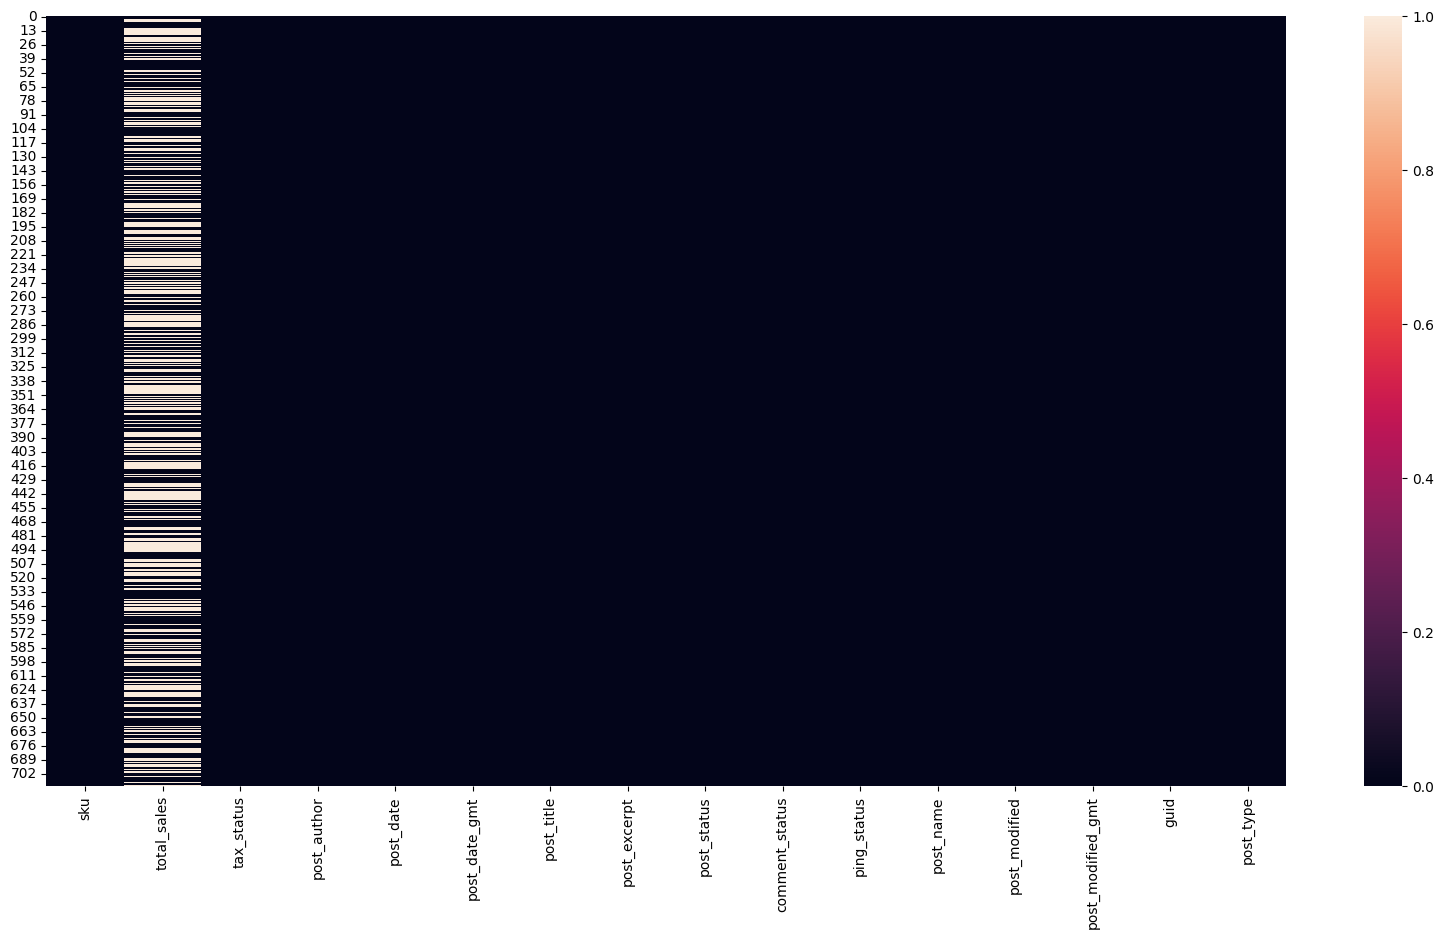

In [192]:
plt.figure(figsize=(20,10))
sns.heatmap(web.isna())

In [193]:
web.fillna(0, inplace=True)
web

,sku,total_sales,tax_status,post_author,post_date,post_date_gmt,post_title,post_excerpt,post_status,comment_status,ping_status,post_name,post_modified,post_modified_gmt,guid,post_type
0,15075,3.0,taxable,2.0,2018-02-14 15:39:43,2018-02-14 14:39:43,Parés Baltà Penedès Indigena 2017,Des couleurs et aromes intenses où le fruit et...,publish,closed,closed,pares-balta-penedes-indigena-2017,2020-08-20 15:35:02,2020-08-20 13:35:02,https://www.bottle-neck.fr/?post_type=product&...,product
1,16209,6.0,taxable,2.0,2018-02-14 17:15:31,2018-02-14 16:15:31,Maurel Cabardès Tradition 2017,"Un joli nez aux arômes de fruits rouges, de ca...",publish,closed,closed,maurel-cabardes-tradition-2017,2020-08-05 18:05:03,2020-08-05 16:05:03,https://www.bottle-neck.fr/?post_type=product&...,product
2,13895,0.0,taxable,2.0,2019-03-19 10:41:50,2019-03-19 09:41:50,Château Saransot-Dupré Bordeaux Blanc 2016,Rareté en Médoc (mais d’A.O.C. Bordeaux) le do...,publish,closed,closed,chateau-saransot-dupre-bordeaux-blanc-2016,2020-04-25 21:11:40,2020-04-25 19:11:40,https://www.bottle-neck.fr/?post_type=product&...,product
3,12857,0.0,taxable,2.0,2018-04-12 17:56:13,2018-04-12 15:56:13,Château de Meursault Puligny-Montrachet 1er Cr...,Il présente une grande fraîcheur minérale au n...,publish,closed,closed,chateau-de-puligny-montrachet-1cru-champ-canet...,2020-02-06 16:35:02,2020-02-06 15:35:02,https://www.bottle-neck.fr/?post_type=product&...,product
4,14106,0.0,taxable,2.0,2019-06-08 09:54:21,2019-06-08 07:54:21,Stéphane Tissot Château-Chalon 2011,Ce vin peut-être dégusté sur sa jeunesse mais ...,publish,closed,closed,stephane-tissot-chateau-chalon-2011,2020-05-29 17:35:03,2020-05-29 15:35:03,https://www.bottle-neck.fr/?post_type=product&...,product
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
709,15941,4.0,taxable,2.0,2018-02-12 14:26:52,2018-02-12 13:26:52,Domaine de la Jérôme Côtes du Rhône Village 201,"Un vin opulent, à la texture onctueuse, et tou...",publish,closed,closed,jerome-cotes-du-rhone-2018,2020-06-25 14:00:03,2020-06-25 12:00:03,https://www.bottle-neck.fr/?post_type=product&...,product
710,10459,0.0,taxable,2.0,2018-04-13 15:58:19,2018-04-13 13:58:19,Alphonse Mellot Sancerre Rouge Génération XIX ...,"Robe d'un superbe rubis, dense et profond - As...",publish,closed,closed,alphonse-mellot-sancerre-rouge-generation-xix-...,2020-08-24 14:05:02,2020-08-24 12:05:02,https://www.bottle-neck.fr/?post_type=product&...,product
711,16320,3.0,taxable,2.0,2018-02-12 12:49:29,2018-02-12 11:49:29,Mourgues du Grès IGP Pont du Gard Terre d'Arge...,"Magnifique exemple d’assemblage réussi, ou cha...",publish,closed,closed,mourgues-du-gres-costieres-de-nimes-terre-darg...,2020-08-25 11:15:03,2020-08-25 09:15:03,https://www.bottle-neck.fr/?post_type=product&...,product
712,15663,3.0,taxable,2.0,2018-02-27 10:27:01,2018-02-27 09:27:01,Chermette Domaine du Vissoux Brouilly Pierreux...,Le Brouilly est le plus méridional des crus du...,publish,closed,closed,chermette-domaine-du-vissoux-brouilly-pierreux...,2020-08-01 09:35:02,2020-08-01 07:35:02,https://www.bottle-neck.fr/?post_type=product&...,product


In [194]:
web['sku'].nunique()

714

<div style="background-color: RGB(0,150,250);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">Etape 5 - Analyse du fichier web avec erp_liaison</h2>
</div>

In [195]:
erp_liaison_web = pd.merge(web,erp_liaison, how="left", on="sku")
erp_liaison_web.head(1)

,sku,total_sales,tax_status,post_author,post_date,post_date_gmt,post_title,post_excerpt,post_status,comment_status,...,post_name,post_modified,post_modified_gmt,guid,post_type,product_id,onsale_web,price,stock_quantity,stock_status_ok
0,15075,3.0,taxable,2.0,2018-02-14 15:39:43,2018-02-14 14:39:43,Parés Baltà Penedès Indigena 2017,Des couleurs et aromes intenses où le fruit et...,publish,closed,...,pares-balta-penedes-indigena-2017,2020-08-20 15:35:02,2020-08-20 13:35:02,https://www.bottle-neck.fr/?post_type=product&...,product,4165,1,12.0,57,instock


In [196]:
#On va supprimer toutes les colonnes inutiles
supp_colonne = ['tax_status', 'post_author',
'post_date_gmt', 'post_status',
'comment_status', 'ping_status', 'post_modified',
'post_modified_gmt',  'post_type',  'onsale_web']
erp_liaison_web.columns

Index(['sku', 'total_sales', 'tax_status', 'post_author', 'post_date',
       'post_date_gmt', 'post_title', 'post_excerpt', 'post_status',
       'comment_status', 'ping_status', 'post_name', 'post_modified',
       'post_modified_gmt', 'guid', 'post_type', 'product_id', 'onsale_web',
       'price', 'stock_quantity', 'stock_status_ok'],
      dtype='object')

In [197]:
erp_liaison_web = erp_liaison_web.drop(columns=supp_colonne).reset_index(drop=True)
erp_liaison_web

,sku,total_sales,post_date,post_title,post_excerpt,post_name,guid,product_id,price,stock_quantity,stock_status_ok
0,15075,3.0,2018-02-14 15:39:43,Parés Baltà Penedès Indigena 2017,Des couleurs et aromes intenses où le fruit et...,pares-balta-penedes-indigena-2017,https://www.bottle-neck.fr/?post_type=product&...,4165,12.0,57,instock
1,16209,6.0,2018-02-14 17:15:31,Maurel Cabardès Tradition 2017,"Un joli nez aux arômes de fruits rouges, de ca...",maurel-cabardes-tradition-2017,https://www.bottle-neck.fr/?post_type=product&...,4174,5.7,94,instock
2,13895,0.0,2019-03-19 10:41:50,Château Saransot-Dupré Bordeaux Blanc 2016,Rareté en Médoc (mais d’A.O.C. Bordeaux) le do...,chateau-saransot-dupre-bordeaux-blanc-2016,https://www.bottle-neck.fr/?post_type=product&...,5796,12.5,12,instock
3,12857,0.0,2018-04-12 17:56:13,Château de Meursault Puligny-Montrachet 1er Cr...,Il présente une grande fraîcheur minérale au n...,chateau-de-puligny-montrachet-1cru-champ-canet...,https://www.bottle-neck.fr/?post_type=product&...,4582,109.6,7,instock
4,14106,0.0,2019-06-08 09:54:21,Stéphane Tissot Château-Chalon 2011,Ce vin peut-être dégusté sur sa jeunesse mais ...,stephane-tissot-chateau-chalon-2011,https://www.bottle-neck.fr/?post_type=product&...,6106,74.8,15,instock
...,...,...,...,...,...,...,...,...,...,...,...
709,15941,4.0,2018-02-12 14:26:52,Domaine de la Jérôme Côtes du Rhône Village 201,"Un vin opulent, à la texture onctueuse, et tou...",jerome-cotes-du-rhone-2018,https://www.bottle-neck.fr/?post_type=product&...,4074,12.7,50,instock
710,10459,0.0,2018-04-13 15:58:19,Alphonse Mellot Sancerre Rouge Génération XIX ...,"Robe d'un superbe rubis, dense et profond - As...",alphonse-mellot-sancerre-rouge-generation-xix-...,https://www.bottle-neck.fr/?post_type=product&...,4617,67.5,1,instock
711,16320,3.0,2018-02-12 12:49:29,Mourgues du Grès IGP Pont du Gard Terre d'Arge...,"Magnifique exemple d’assemblage réussi, ou cha...",mourgues-du-gres-costieres-de-nimes-terre-darg...,https://www.bottle-neck.fr/?post_type=product&...,4062,11.9,60,instock
712,15663,3.0,2018-02-27 10:27:01,Chermette Domaine du Vissoux Brouilly Pierreux...,Le Brouilly est le plus méridional des crus du...,chermette-domaine-du-vissoux-brouilly-pierreux...,https://www.bottle-neck.fr/?post_type=product&...,4262,15.8,35,instock


<div style="background-color: RGB(0,150,250);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">Etape 6 - Calcul des CA produits et totaux</h2>
</div>

In [198]:
# Creation d'une colonne contenant le chiffre d'affaire par produits + CA total en ligne:
erp_liaison_web["ca_produit"] = round(erp_liaison_web["price"]*erp_liaison_web["total_sales"], 2)
erp_liaison_web.head()

,sku,total_sales,post_date,post_title,post_excerpt,post_name,guid,product_id,price,stock_quantity,stock_status_ok,ca_produit
0,15075,3.0,2018-02-14 15:39:43,Parés Baltà Penedès Indigena 2017,Des couleurs et aromes intenses où le fruit et...,pares-balta-penedes-indigena-2017,https://www.bottle-neck.fr/?post_type=product&...,4165,12.0,57,instock,36.0
1,16209,6.0,2018-02-14 17:15:31,Maurel Cabardès Tradition 2017,"Un joli nez aux arômes de fruits rouges, de ca...",maurel-cabardes-tradition-2017,https://www.bottle-neck.fr/?post_type=product&...,4174,5.7,94,instock,34.2
2,13895,0.0,2019-03-19 10:41:50,Château Saransot-Dupré Bordeaux Blanc 2016,Rareté en Médoc (mais d’A.O.C. Bordeaux) le do...,chateau-saransot-dupre-bordeaux-blanc-2016,https://www.bottle-neck.fr/?post_type=product&...,5796,12.5,12,instock,0.0
3,12857,0.0,2018-04-12 17:56:13,Château de Meursault Puligny-Montrachet 1er Cr...,Il présente une grande fraîcheur minérale au n...,chateau-de-puligny-montrachet-1cru-champ-canet...,https://www.bottle-neck.fr/?post_type=product&...,4582,109.6,7,instock,0.0
4,14106,0.0,2019-06-08 09:54:21,Stéphane Tissot Château-Chalon 2011,Ce vin peut-être dégusté sur sa jeunesse mais ...,stephane-tissot-chateau-chalon-2011,https://www.bottle-neck.fr/?post_type=product&...,6106,74.8,15,instock,0.0


In [199]:
Ca_Tot = sum(erp_liaison_web["ca_produit"])
print(f"Le chiffre d'affaire total est de {Ca_Tot} €")

Le chiffre d'affaire total est de 70568.6 €


<div style="background-color: RGB(0,150,250);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">Etape 7 - Analyse des prix et représentation graphique: (outliers)</h2>
</div>

In [200]:
erp_liaison_web["price"].describe()


count    714.000000
mean      32.493137
std       27.810525
min        5.200000
25%       14.100000
50%       23.550000
75%       42.175000
max      225.000000
Name: price, dtype: float64

**La méthode .describe nous donne un résumé statistique basique de la colonne price de notre dataframe.**
* Nous avons donc 714 valeurs avec 5,20€ pour le prix minimum et 225€ pour le prix maximum.
* Nous avons aussi les premier et troisème percentiles ainsi que la médiane (second percentil, 50%) à 23,55€.
* l'écart type est de 27,81€ envirron
* La moyenne de 32,49€. On note qu'elle est différente de la médiane.


/Users/ishemzerzour/Desktop/My Program Files/Projet_5-BottleNeck/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Répartition des prix')

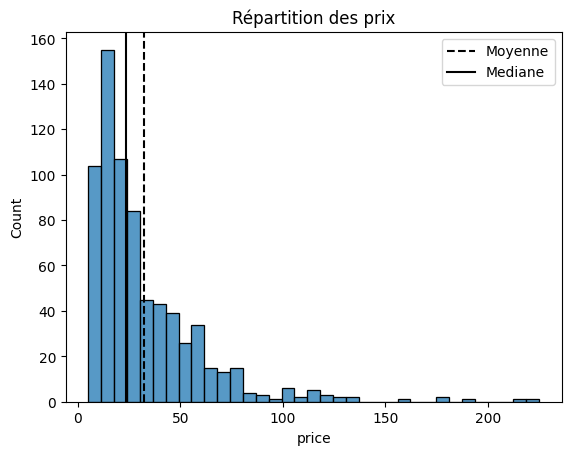

In [201]:
moyenne = erp_liaison_web["price"].mean()
mediane = erp_liaison_web["price"].median()

#Representation de la repartition des prix en histogramme:
sns.histplot(data=erp_liaison_web["price"])
plt.axvline(moyenne, color="black", linestyle="--")
plt.axvline(mediane, color="black", linestyle="-")
plt.legend({"Moyenne":moyenne,"Mediane":mediane})
plt.title("Répartition des prix")

**On peut voir la moyenne et la médiane. La médiane est décalée sur la gauche de notre graphique, les premiers prix sont donc plus fréquents dans notre boutique que les plus élevé. Visuellement et sans avoir encore de confirmation tangible il semblerait que les outliers se retrouvent plutôt parmi les prix élevés.**

In [202]:
# Calcul des quartiles
Q1 = round(erp_liaison_web['price'].quantile(0.25), 2)
Q3 = round(erp_liaison_web['price'].quantile(0.75), 2)

# Calcul de l'IQR (écart inter quartile)
IQR = round(Q3 - Q1, 2)

# Identification des outliers
outliers_iqr = erp_liaison_web[(erp_liaison_web['price'] < Q1 - 1.5 * IQR) | (erp_liaison_web['price'] > Q3 + 1.5 * IQR)]

print(f"Q1 = {Q1} €")
print(f"Q2 = {Q3} €")
print(f"IQR = {IQR} €")

print(f"les prix situés en dehors de l'intervalle {round(Q1 - 1.5 * IQR,2)}€ et {round(Q3 + 1.5 * IQR,2)}€ sont des outliers potentielles")




Q1 = 14.1 €
Q2 = 42.18 €
IQR = 28.08 €
les prix situés en dehors de l'intervalle -28.02€ et 84.3€ sont des outliers potentielles


In [203]:
# Liste des outliers
print("Outliers identifiés par IQR:")
outliers_iqr = outliers_iqr.sort_values(['price'], ascending=[False])
outliers_iqr.head()

Outliers identifiés par IQR:


,sku,total_sales,post_date,post_title,post_excerpt,post_name,guid,product_id,price,stock_quantity,stock_status_ok,ca_produit
670,15940,5.0,2018-03-02 10:30:04,Champagne Egly-Ouriet Grand Cru Millésimé 2008,Issu d’un assemblage de 70% de Pinot Noir du g...,champagne-egly-ouriet-grand-cru-millesime-2008,https://www.bottle-neck.fr/?post_type=product&...,4352,225.0,0,outofstock,1125.0
315,14581,0.0,2018-07-17 09:45:39,David Duband Charmes-Chambertin Grand Cru 2014,Robe cerise chatoyante. Un nez de fruits rouge...,david-duband-charmes-chambertin-grand-cru-2014,https://www.bottle-neck.fr/?post_type=product&...,5001,217.5,20,instock,0.0
559,14983,3.0,2019-03-28 10:21:36,Coteaux Champenois Egly-Ouriet Ambonnay Rouge ...,Cet Ambonnay évoque les grands Pinots Noirs de...,coteaux-champenois-egly-ouriet-ambonnay-rouge-...,https://www.bottle-neck.fr/?post_type=product&...,5892,191.3,10,instock,573.9
186,3510,13.0,2018-03-22 11:21:05,Cognac Frapin VIP XO,La cuvée VIP XO à été enrichie d’eaux-de-vie t...,cognac-frapin-vip-xo,https://www.bottle-neck.fr/?post_type=product&...,4402,176.0,8,instock,2288.0
177,15185,0.0,2019-03-13 14:43:22,Camille Giroud Clos de Vougeot 2016,Ce vin provient de vignes âgées de 50 ans situ...,camille-giroud-clos-de-vougeot-2016,https://www.bottle-neck.fr/?post_type=product&...,5767,175.0,12,instock,0.0


In [204]:
print("le nombre d'outiliers est de :",outliers_iqr.shape[0])

le nombre d'outiliers est de : 32


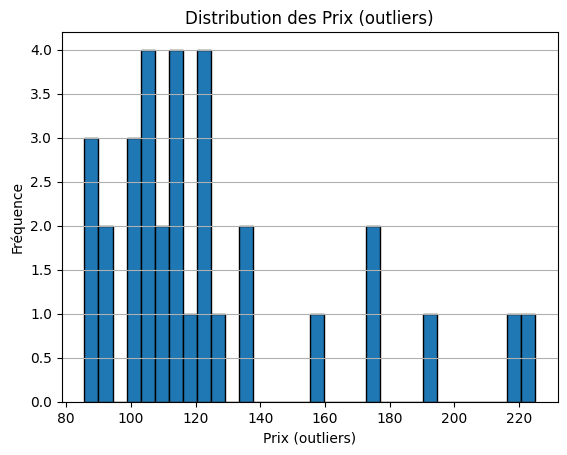

In [205]:
# Distribution des prix sur les données aberrantes
plt.hist(outliers_iqr["price"], bins=32, edgecolor="black")
plt.xlabel("Prix (outliers)")
plt.ylabel("Fréquence")
plt.title("Distribution des Prix (outliers)")
plt.grid(axis="y", visible=True, )
plt.show()

In [206]:
#Faux et vrai outlier : Hypothèse : Il y a plus de chance que les outliers "rééllement" anormaux soit des valeurs qui apparaissent 1 fois.

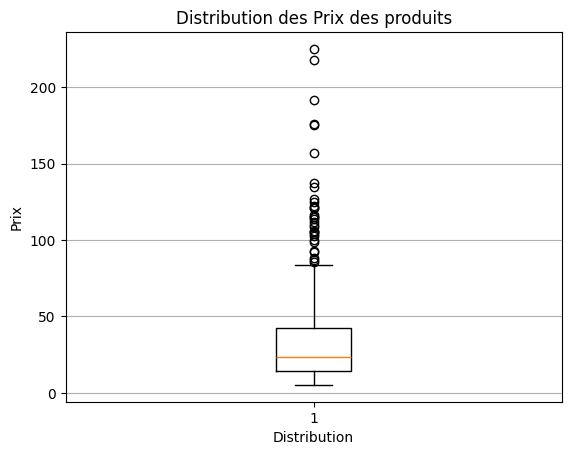

In [207]:
#Boxplot de tout les prix du dataframe final
plt.boxplot(erp_liaison_web['price'])
plt.xlabel("Distribution")
plt.ylabel("Prix")
plt.title("Distribution des Prix des produits")
plt.grid(axis="y")
plt.show()

**Tous les points au dessus de la limite (84,35€) sont de possible outliers**

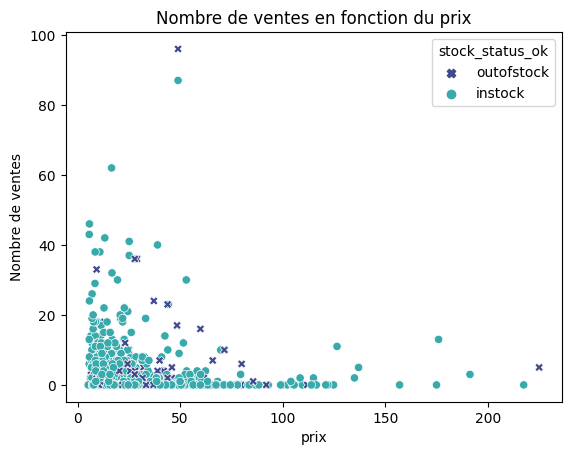

In [208]:
#Representation graphique en nuage de points:
sns.scatterplot(data=erp_liaison_web,
                x="price",
                y="total_sales",
                hue="stock_status_ok",
                style="stock_status_ok",
                palette="mako",
                hue_order=("outofstock","instock"))
plt.xlabel("prix")
plt.ylabel("Nombre de ventes")
plt.title("Nombre de ventes en fonction du prix")
plt.show()

In [209]:
# Ligne ou le prix est le plus élevé
max_price = erp_liaison_web["price"].max()
max_price_row = erp_liaison_web.loc[erp_liaison_web["price"] == max_price]
max_price_row

,sku,total_sales,post_date,post_title,post_excerpt,post_name,guid,product_id,price,stock_quantity,stock_status_ok,ca_produit
670,15940,5.0,2018-03-02 10:30:04,Champagne Egly-Ouriet Grand Cru Millésimé 2008,Issu d’un assemblage de 70% de Pinot Noir du g...,champagne-egly-ouriet-grand-cru-millesime-2008,https://www.bottle-neck.fr/?post_type=product&...,4352,225.0,0,outofstock,1125.0


Nous sommes à court de la bouteille la plus chère - 225€ pour le Champagne Egly-Ouriet Grand Cru Millésimé 2008

In [210]:
# Ligne ou le nombre de vente est le plus élevé
max_sales = erp_liaison_web["total_sales"].max()
max_sales_row = erp_liaison_web.loc[erp_liaison_web["total_sales"] == max_sales]
max_sales_row

,sku,total_sales,post_date,post_title,post_excerpt,post_name,guid,product_id,price,stock_quantity,stock_status_ok,ca_produit
365,7818,96.0,2018-03-01 14:02:44,Champagne Gosset Grand Blanc de Blancs,La bulle fine et presente se dirige vers la su...,champagne-gosset-grand-blanc-de-blanc,https://www.bottle-neck.fr/?post_type=product&...,4334,49.0,0,outofstock,4704.0


Nous sommes à court de notre bestseller - 96 ventes à 49€ pour le Champagne Gosset Grand Blanc de Blancs

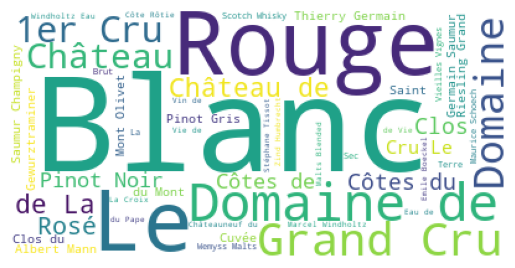

In [211]:
#Wordcloud
text = ' '.join(web['post_title'].astype(str))
exclure_mots = ['de''Le']

wordcloud = WordCloud(background_color='white',stopwords=exclure_mots , max_words=50).generate(text)
# Generate the plot
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

<div style="background-color: RGB(0,150,250);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">Etape 8 - Conclusions</h2>
</div>

Nos recommendations :

Dans un premier temps : Identifier et corriger les erreurs de saisie des données actuelles grâce aux acteurs métiers. Cela permettra d'améliorer la fiabilité des analyses de vente et de la prise de décision.

Dans un second temps : Mettre en place un système centralisé des produits et ventes en ligne afin de gagner en simplicité de gestion et fiabilité des données comme shopify par exemple. Unifier les produits par "produit" et non par annonce en lignes

Dans un troisième temps : Intégrer un système d'analytics sur votre site (Google Analytics) afin d'acquérir des insights supplémentaires sur le comportement des utilisateurs en ligne (produits davantages consulter ? Villes/Pays d'achat ?...)


Les erreurs notés sur le projet: 
- Des prix négatifs 'erp' remplacer par la valeur absolu positive
- Des stocks négatifs 'erp' remplacer par la valeur absolu positive
- Stock_status 'erp' incohérants (outofstock alors qu'il y a du stock") remplacer par le stock_status réel
- Encodage 'web' sur la colonne "post_excerpt" appliquer un html.parser
- fichier liaison - id_web remplacer par "sku" 
- fichier liaison - product_id integer remplacer par object
- 32 lignes Outliers 
- 2 sku dans 'web' qui sont à 2 chiffres -> 38 et 42 - Ils ont leurs équivalent product_id donc je les laisses 